In [1]:
cd gamedata

/Users/benyeagley/Desktop/sp19-222-92/project/gamedata


In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv("total_game_data2.csv")
data.head()

,Class,HR min [bpm],HR avg [bpm],HR max [bpm],HR min [%],HR avg [%],HR max [%],Time in HR zone 1 (50 - 59 %),Time in HR zone 2 (60 - 69 %),Time in HR zone 3 (70 - 79 %),...,Number of accelerations (-1.99 - -1.00 m/s),Number of accelerations (-0.99 - -0.50 m/s),Number of accelerations (0.50 - 0.99 m/s),Number of accelerations (1.00 - 1.99 m/s),Number of accelerations (2.00 - 2.99 m/s),Number of accelerations (3.00 - 50.00 m/s),Calories [kcal],Training load score,Recovery time [h],Min Played
0,Forward,37,148,210,19,74,105,0:19:22,0:27:11,0:56:50,...,399,762,593,389,119,19,1343,230,46.0,99
1,Midfielder,62,98,188,31,49,94,0:23:49,0:08:11,0:08:23,...,82,239,211,69,12,0,495,30,5.5,0
2,Forward,80,150,217,40,75,109,0:28:32,0:20:40,0:15:03,...,302,601,500,333,97,11,1407,289,135.7,82
3,Defender,86,150,200,43,75,100,0:19:42,0:15:29,0:19:19,...,352,590,647,360,77,12,1462,302,151.4,79
4,Defender,83,121,192,42,61,96,1:23:38,0:25:26,0:11:26,...,129,325,276,118,21,7,1019,118,21.3,7


In [4]:
# Removes every row where a player had zero minutes played
data = data[data['Min Played'] != 0]

In [5]:
#Drop Columns
data = data[data.columns.drop(list(data.filter(regex='Time')))]
data = data[data.columns.drop(list(data.filter(regex='HR')))]
data = data[data.columns.drop(list(data.filter(regex='Calories')))]
data = data[data.columns.drop(list(data.filter(regex='load score')))]
data = data[data.columns.drop(list(data.filter(regex='Recovery')))]
data = data[data.columns.drop(list(data.filter(regex='Speed zone 1')))]
labels = data['Class']
data = data[data.columns.drop(list(data.filter(regex='Class')))]

data = data.reset_index(drop=True)

In [6]:
# Column names to use in later loop
distance_columns = ('Distance in Speed zone 2 [yd] (0.10 - 2.59 mph)', 'Distance in Speed zone 3 [yd] (2.60 - 5.13 mph)', 'Distance in Speed zone 4 [yd] (5.14 - 8.38 mph)', 'Distance in Speed zone 5 [yd] (8.39- mph)')
accel_columns = ('Number of accelerations (-50.00 - -3.00 m/s)', 'Number of accelerations (-2.99 - -2.00 m/s)', 'Number of accelerations (-1.99 - -1.00 m/s)', 'Number of accelerations (-0.99 - -0.50 m/s)', 'Number of accelerations (0.50 - 0.99 m/s)', 'Number of accelerations (1.00 - 1.99 m/s)', 'Number of accelerations (2.00 - 2.99 m/s)', 'Number of accelerations (3.00 - 50.00 m/s)')

# Create new column for total accelerations
data['Total accelerations'] = pd.Series(np.random.randn(len(data)), index=data.index)

# Convert column dtypes to floats for percentage values
data['Sprints'] = data['Sprints'].apply(np.float64)
for i in distance_columns:
    data[i] = data[i].apply(np.float64)
for i in accel_columns:
    data[i] = data[i].apply(np.float64)

# Adjust sprints for minutes played, adjust speed zones for total distance, and get total accelerations
for index, row in data.iterrows():
    # Initialize total acceleration value
    total_accels = 0
    # Change # of sprints to sprints per min
    data.at[index, 'Sprints'] = row['Sprints'] / row['Min Played']
    # Divide distance in speed zone by total distance, save back in speed zone column
    for i in distance_columns:
        data.at[index, i] = (row[i]) / int(row['Total distance [yd]'])
    # Calculate total # of accelerations and save in new column
    for i in accel_columns:
        total_accels += row[i]
    data.at[index, 'Total accelerations'] = total_accels

# Second loop to divide each acceleration column by the total accelerations, save back in acceleration columns
for index, row in data.iterrows():
    for i in accel_columns:
        data.at[index, i] = (row[i]) / int(row['Total accelerations'])

In [7]:
# Normalize
from sklearn import preprocessing

x = data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
data = pd.DataFrame(x_scaled)

# Save changes in new csv to view later. Will be moved to after normalization
data.to_csv("altered_total.csv")

In [8]:
# Shuffle the data
import random
for i in range(19):
    random.shuffle(data[i])

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, labels], axis = 1)

In [10]:
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (15,15) 
plt.rcParams['font.size'] = 25 
plt.rcParams['lines.markersize'] = 7

[m,n] = data.shape

mat = data.values

ind1 = 4; ind2 = 11
X = np.zeros((m,2))
X[:,0] = mat[:,ind1]; X[:,1] = mat[:,ind2]


plt.scatter( mat[:,ind1] , mat[:,ind2] , alpha=0.5 );
plt.plot()

[]

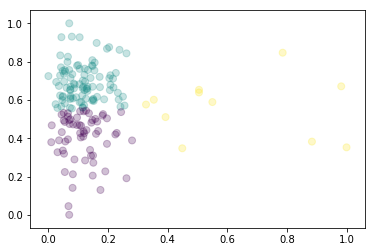

In [11]:
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering( n_clusters=3 ) # instantiate the k-means model, with 3 clusters
spectral.fit(X) # build the model # plot the results!
plt.scatter( X[:,0],X[:,1], c=spectral.labels_, alpha=0.25 )

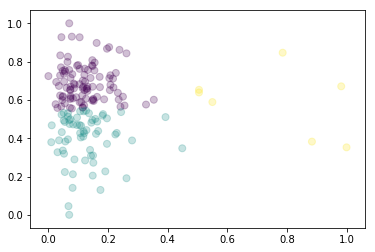

In [12]:
from sklearn.cluster import KMeans# import K-Means clustering 
kmeans=KMeans(n_clusters=3 );# instantiate the k-means model, with 3 clusters
kmeans.fit( X ); # build the model # plot the results!
plt.scatter( X[:,0],X[:,1], c=kmeans.labels_, alpha=0.25 )
